In [1]:

import numpy as np
import pickle
import lzma
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.typing import NDArray
from experiment import AgentStats, Results
from typing import List, Dict
from scipy.ndimage import gaussian_filter
from matplotlib.colors import Normalize

In [2]:
TITLE_SIZE = 22
LEGEND_SIZE = 14
TICK_SIZE = 14
AXIS_TITLE = TITLE_SIZE-4
AXIS_LABEL = 16
FONT_SIZE = TITLE_SIZE-4

rc_parameters = {
    "font.size": FONT_SIZE,
    "axes.titlesize": AXIS_TITLE,
    "axes.labelsize": AXIS_LABEL,
    "xtick.labelsize": TICK_SIZE,
    "ytick.labelsize": TICK_SIZE,
    "legend.fontsize": LEGEND_SIZE,
    "figure.titlesize": TITLE_SIZE,
    "font.family": "serif",  # use serif/main font for text elements
    "text.usetex": True,  # use inline math for ticks
    "pgf.rcfonts": False,  # don't setup fonts from rc parameters
    "pgf.preamble":  r'\usepackage{amsmath}'
}
plt.rcParams.update(rc_parameters)


In [3]:
agents = ['dbmfbpi','bsp', 'ids']
titles = {
    'dbmfbpi': 'Model-Free Best Policy\nIdentification (ours)',
    'bsp': 'Boostrapped DQN with\n Randomized Prior',
    'ids': 'Information Directed\nSampling'
}
difficulty = 3
data = {}
for agent in agents:
    data[agent] = {}
    with lzma.open(f'data//data_{difficulty}_{agent}.pkl.lzma', 'rb') as f:
        data[agent][difficulty] = pickle.load(f)


In [4]:
T = 20000   # Total timesteps considered
runs = 30    # Specify number of runs
x = np.zeros((3, runs, T))
xdot = np.zeros((3, runs, T))
theta = np.zeros((3, runs, T))
thetadot = np.zeros((3, runs, T))
timestamps = np.zeros((3, runs,T))

for idx, agent in enumerate(['bsp', 'ids', 'dbmfbpi']):
    for n in range(runs):
        timesteps, episodes, states, actions= map(np.array, zip(*data[agent][difficulty][n].agent_stats.states_actions_visited))
        timestamps[idx, n, :] = timesteps[:T]
        x[idx, n, :]= states[:T,0]
        xdot[idx, n, :] = states[:T,1]
        theta[idx, n, :] = np.arctan2(states[:T, 3], states[:T, 2])
        thetadot[idx, n, :] = states[:T, 4]

x, xdot, theta, thetadot,timestamps = x.reshape(3, -1), xdot.reshape(3, -1), theta.reshape(3, -1), thetadot.reshape(3, -1), timestamps.reshape(3,-1)



/tmp/ipykernel_31039/3048282815.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('magma_r')


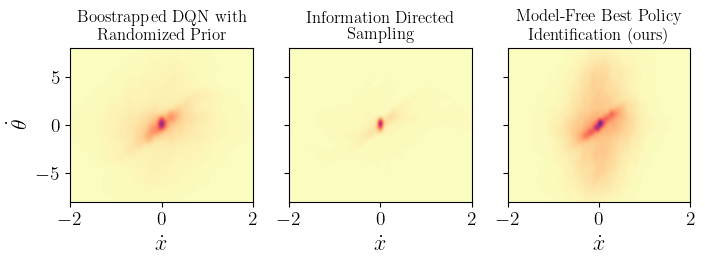

In [5]:
fig,ax = plt.subplots(1,3, figsize=(8,2), sharex=True, sharey=True)
bins = 100
cmap = plt.cm.get_cmap('magma_r')

def make_plot(ax, var1, var2, bins):
    hist, xedges, yedges = np.histogram2d(var1,var2,bins=bins)

    X, Y = np.meshgrid(xedges, yedges)
    min_val = np.min(hist)
    max_val = np.max(hist)

    # Normalize the histogram
    normalized_hist = (hist - min_val) / (max_val - min_val)

    cax = ax.imshow(normalized_hist.T, interpolation='bicubic', origin='lower',
                         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                         cmap=cmap, aspect='auto')

for idx, agent in enumerate(['bsp', 'ids', 'dbmfbpi']):
    var1, var2,tm = xdot[idx,:], thetadot[idx,:], timestamps[idx,:]
    make_plot(ax[idx], var1, var2, bins)

    ax[idx].set_xlim(-2,2)
    ax[idx].set_ylim(-8,8)
    ax[idx].set_xlabel(r'$\dot x$')
    ax[idx].set_title(titles[agent], fontsize=12, ha='center')
ax[0].set_ylabel(r'$\dot\theta$')

plt.savefig(f'figures/exploration_frequency_visit_{difficulty}_xdot_thetadot.pdf', bbox_inches='tight')
plt.show()


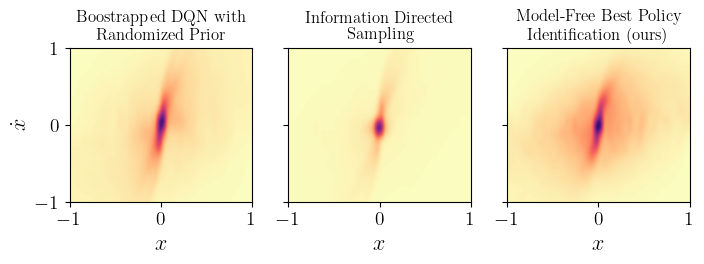

In [6]:
fig,ax = plt.subplots(1,3, figsize=(8,2), sharex=True, sharey=True)
for idx, agent in enumerate(['bsp', 'ids', 'dbmfbpi']):
    var1, var2,tm = x[idx,:], xdot[idx,:], timestamps[idx,:]
    make_plot(ax[idx], var1, var2, 50)

    ax[idx].set_xlim(-1,1)
    ax[idx].set_ylim(-1,1)
    ax[idx].set_xlabel(r'$x$')
    ax[idx].set_title(titles[agent], fontsize=12, ha='center')
ax[0].set_ylabel(r'$\dot x$')

plt.savefig(f'figures/exploration_frequency_visit_{difficulty}_x_xdot.pdf', bbox_inches='tight')
plt.show()


/tmp/ipykernel_31039/2953530401.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('magma_r')


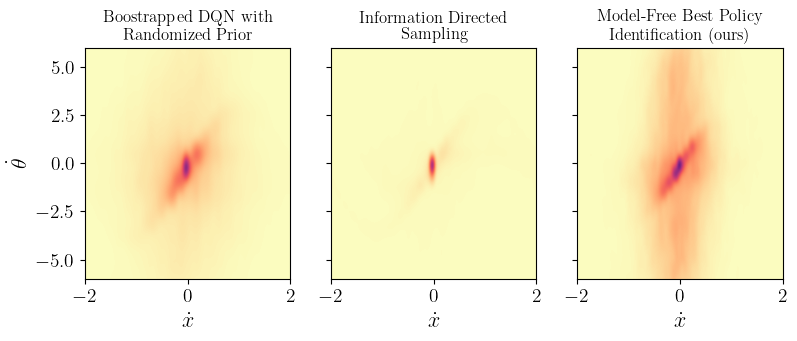

In [7]:
fig,ax = plt.subplots(1,3, figsize=(9,3), sharex=True, sharey=True)
bins = 100
cmap = plt.cm.get_cmap('magma_r')

for idx, agent in enumerate(['bsp', 'ids', 'dbmfbpi']):
    var1, var2,tm = xdot[idx,:], thetadot[idx,:], timestamps[idx,:]
    hist, xedges, yedges = np.histogram2d(var1,var2,bins=bins)
    X, Y = np.meshgrid(xedges, yedges)
    recency_map = np.full((bins+1, bins+1), 0)
    for t,v1,v2 in zip(tm, var1,var2):
        x_idx = np.digitize(v1, xedges) - 1
        y_idx = np.digitize(v2, yedges) - 1
        recency_map[x_idx, y_idx] += t
        
    recency_map = recency_map / runs

    #recency_map = gaussian_filter(recency_map, sigma=7)
    cax = ax[idx].imshow(recency_map.T, interpolation='bicubic', origin='lower',
                         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                         cmap=cmap, aspect='auto')

    ax[idx].set_xlim(-2, 2)
    ax[idx].set_ylim(-6, 6)
    ax[idx].set_xlabel(r'$\dot x$')
    ax[idx].set_title(titles[agent], fontsize=12, ha='center')
ax[0].set_ylabel(r'$\dot \theta$')

plt.savefig(f'figures/exploration_last_visit_{difficulty}_xdot_thetadot.pdf', bbox_inches='tight')
plt.show()





/tmp/ipykernel_31039/537403588.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('magma_r')


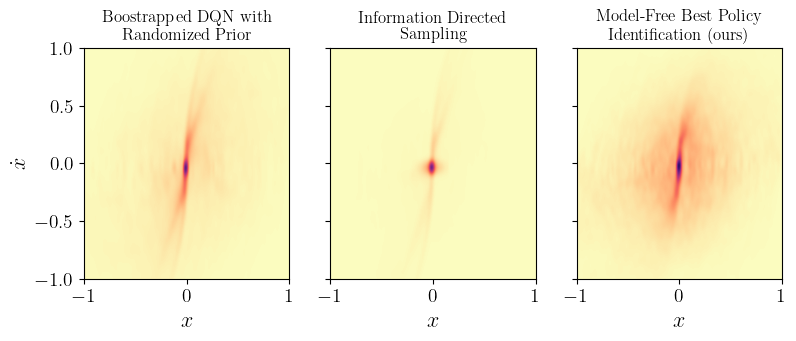

In [8]:
fig,ax = plt.subplots(1,3, figsize=(9,3), sharex=True, sharey=True)
bins = 100
cmap = plt.cm.get_cmap('magma_r')

for idx, agent in enumerate(['bsp', 'ids', 'dbmfbpi']):
    var1, var2,tm = x[idx,:], xdot[idx,:], timestamps[idx,:]
    hist, xedges, yedges = np.histogram2d(var1,var2,bins=bins)
    X, Y = np.meshgrid(xedges, yedges)
    recency_map = np.full((bins+1, bins+1), 0)
    for t,v1,v2 in zip(tm, var1,var2):
        x_idx = np.digitize(v1, xedges) - 1
        y_idx = np.digitize(v2, yedges) - 1
        recency_map[x_idx, y_idx] += t
        
    recency_map = recency_map / runs

    cax = ax[idx].imshow(recency_map.T, interpolation='bicubic', origin='lower',
                         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                         cmap=cmap, aspect='auto')

    ax[idx].set_xlim(-1, 1)
    ax[idx].set_ylim(-1, 1)
    ax[idx].set_xlabel(r'$x$')
    ax[idx].set_title(titles[agent], fontsize=12, ha='center')
ax[0].set_ylabel(r'$\dot x$')

plt.savefig(f'figures/exploration_last_visit_{difficulty}_x_xdot.pdf', bbox_inches='tight')
plt.show()



